# Cascadia Landslide Data Post-Processing
## ShakeMap Integration and Unique ID Addition

This notebook performs final post-processing on Cascadia landslide dataset:
- Adding USGS M9 scenario ShakeMap seismic intensity data and adding unique identifiers to create the final dataset for visualization and analysis.
- rainfall data from the rainfall notebook

## ShakeMap Integration

This notebook integrates USGS ShakeMap intensity data with Cascadia landslide location data. The ShakeMap data is available at https://earthquake.usgs.gov/scenarios/eventpage/cszm9ensemble_se/shakemap/intensity. 

The process involves several key steps:

### 1. Data Loading and Parsing
- Load ShakeMap XML data containing seismic intensity measurements
- Parse XML structure to extract grid fields and data values
- Convert raw XML data into structured pandas DataFrame

### 2. Data Processing
- Extract seismic parameters: MMI (Modified Mercalli Intensity), PGA (Peak Ground Acceleration), PGV (Peak Ground Velocity), and PSA03
- Create spatial interpolators using nearest neighbor interpolation
- Analyze PGA value distributions across different intensity ranges

### 3. Landslide Data Integration
- Calculate centroids for landslide geometries
- Interpolate seismic values at landslide locations using spatial interpolation

### 4. Visualization and Analysis
- Create choropleth maps showing PGA values at landslide locations
- Generate statistical summaries of seismic intensities at landslide sites
- Export final integrated dataset with both geometric and seismic attributes


In [3]:
import pandas as pd
import geopandas as gpd 
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [7]:
xml_file = './shaking/grid.xml'
namespace = {'shakemap': 'http://earthquake.usgs.gov/eqcenter/shakemap'}

# Parse the XML file
tree = ET.parse(xml_file)
root = tree.getroot()

In [8]:
# Get the column names from the <grid_field> tags
fields = root.findall('shakemap:grid_field', namespace)
column_names = [field.get('name') for field in fields]

In [9]:
print(column_names)

['LON', 'LAT', 'PGA', 'PGV', 'MMI', 'PSA03', 'PSA10', 'PSA30']


In [10]:
# Get the grid data, which is a long string of numbers
grid_data_text = root.find('shakemap:grid_data', namespace).text.strip()

In [11]:
# Use Numpy to convert the string into a numerical array
data_array = np.fromstring(grid_data_text, dtype=float, sep=' ')

In [12]:
# Reshape the 1D array into a 2D table (rows x columns)
num_columns = len(column_names)
data_array_2d = data_array.reshape(-1, num_columns)

In [13]:
# Create a pandas DataFrame from the 2D array
shakemap_df = pd.DataFrame(data_array_2d, columns=column_names)

In [14]:
print(shakemap_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532726 entries, 0 to 532725
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   LON     532726 non-null  float64
 1   LAT     532726 non-null  float64
 2   PGA     532726 non-null  float64
 3   PGV     532726 non-null  float64
 4   MMI     532726 non-null  float64
 5   PSA03   532726 non-null  float64
 6   PSA10   532726 non-null  float64
 7   PSA30   532726 non-null  float64
dtypes: float64(8)
memory usage: 32.5 MB
None


In [15]:
print(len(shakemap_df))
print(shakemap_df.head())

532726
      LON   LAT   PGA   PGV   MMI  PSA03  PSA10  PSA30
0 -135.00  50.0  0.63  2.31  3.59   1.56   2.44   1.10
1 -134.98  50.0  0.63  2.32  3.59   1.57   2.45   1.11
2 -134.96  50.0  0.64  2.33  3.60   1.59   2.46   1.12
3 -134.94  50.0  0.65  2.34  3.60   1.61   2.48   1.12
4 -134.92  50.0  0.65  2.36  3.60   1.62   2.49   1.13


In [16]:
# Define the bins for PGA values
# Bins are (0, 2], (2, 4], ..., (48, 50], (50, inf]
bins = list(range(0, 51, 2)) + [float('inf')]

# Create labels for the bins
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-2)] + [f">50"]

# Use pd.cut to categorize PGA values into the defined bins
pga_binned = pd.cut(shakemap_df['PGA'], bins=bins, labels=labels, right=True, include_lowest=True)

# Count the number of values in each bin and sort by the bin range
pga_counts = pga_binned.value_counts().sort_index()

# Print the counts
print("PGA Value Counts in Different Ranges:")
print(pga_counts)

PGA Value Counts in Different Ranges:
PGA
0-2      171379
2-4       85246
4-6       54016
6-8       33317
8-10      23484
10-12     17198
12-14     13986
14-16     11892
16-18      9791
18-20      8243
20-22      7188
22-24      6548
24-26      5987
26-28      5341
28-30      4873
30-32      4881
32-34      5720
34-36      5698
36-38      6851
38-40      7029
40-42      6053
42-44      4698
44-46      2850
46-48      2106
48-50      1463
>50       26888
Name: count, dtype: int64


## open dataset

In [17]:
combined_landslide_path = "../PreProcessing/processed_geojson/oregon_landslides_processed.geojson"
combined_bc_or_wa_landslides_gdf = gpd.read_file(combined_landslide_path)

In [18]:
from scipy.interpolate import NearestNDInterpolator
import numpy as np

points = np.column_stack((shakemap_df['LON'], shakemap_df['LAT']))

interpolators = {
    field: NearestNDInterpolator(points, shakemap_df[field].values)
    for field in ['MMI', 'PGA', 'PGV', 'PSA03']
}


In [17]:
# Calculate the centroid for all geometries. For points, the centroid is the point itself.
combined_bc_or_wa_landslides_gdf['centroid'] = combined_bc_or_wa_landslides_gdf.geometry.centroid

# Ensure the centroid coordinates are in WGS84 (EPSG:4326)
combined_bc_or_wa_landslides_gdf['centroid'] = combined_bc_or_wa_landslides_gdf['centroid'].to_crs(epsg=4326)

# Extract longitude and latitude from the centroid
cr = combined_bc_or_wa_landslides_gdf['centroid']
combined_bc_or_wa_landslides_gdf['lon'] = cr.x
combined_bc_or_wa_landslides_gdf['lat'] = cr.y

# Drop rows where longitude or latitude is missing
combined_bc_or_wa_landslides_gdf.dropna(subset=['lon', 'lat'], inplace=True)

# Prepare the query points for interpolation
query_points_combined = combined_bc_or_wa_landslides_gdf[['lon', 'lat']].values

# Interpolate PGA, MMI, and PGV values using the existing interpolators
combined_bc_or_wa_landslides_gdf['PGA'] = interpolators['PGA'](query_points_combined)
combined_bc_or_wa_landslides_gdf['MMI'] = interpolators['MMI'](query_points_combined)
combined_bc_or_wa_landslides_gdf['PGV'] = interpolators['PGV'](query_points_combined)
combined_bc_or_wa_landslides_gdf['PSA03'] = interpolators['PSA03'](query_points_combined)

# Display the head of the updated dataframe with the new columns
print(combined_bc_or_wa_landslides_gdf[['LANDSLIDE_ID', 'lon', 'lat', 'PGA', 'MMI', 'PGV']].head())

/var/folders/4l/861pz_dj397_gz1sywdvrptw0000gq/T/ipykernel_98735/2828021527.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  combined_bc_or_wa_landslides_gdf['centroid'] = combined_bc_or_wa_landslides_gdf.geometry.centroid


  LANDSLIDE_ID         lon        lat    PGA  MMI    PGV
0     WASH_CO2 -122.883085  45.360998  23.11  7.0  26.60
1     WASH_CO3 -122.883015  45.361595  23.11  7.0  26.60
2     WASH_CO4 -122.881510  45.361090  23.11  7.0  26.60
3     WASH_CO5 -122.880114  45.361913  23.11  7.0  26.60
4     WASH_CO6 -122.885342  45.351418  22.26  7.0  27.73


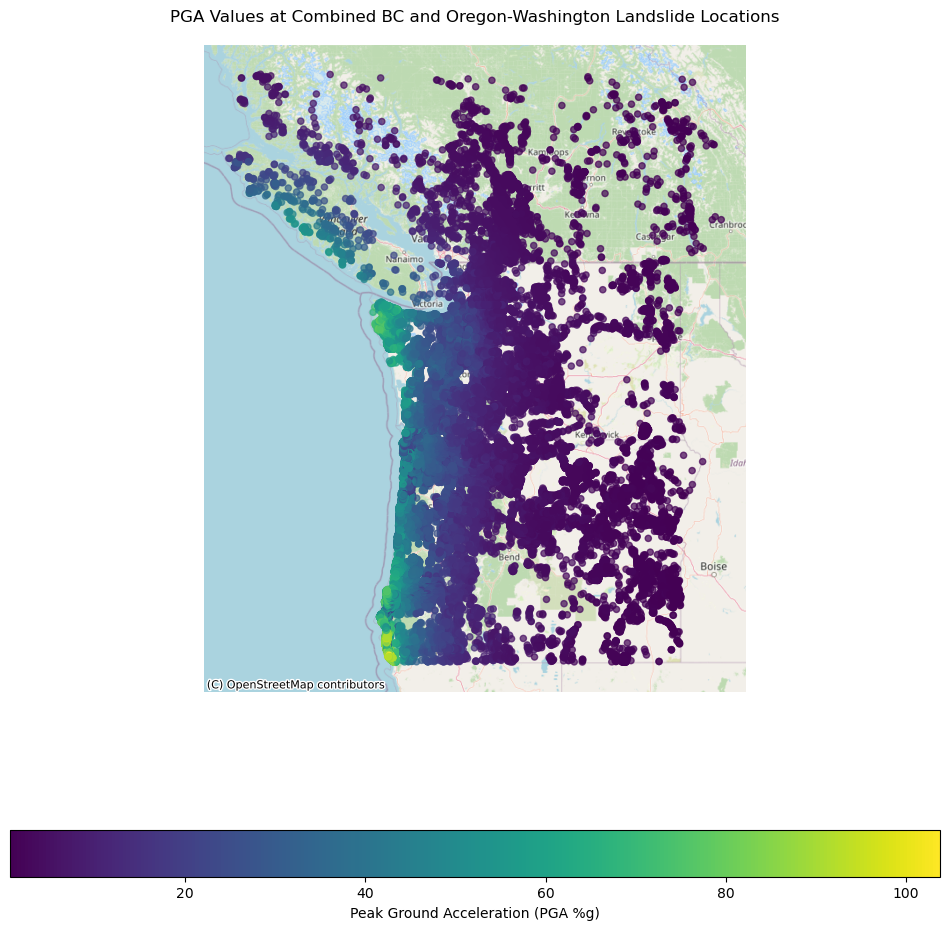

In [18]:
import contextily as cx

# Ensure the geometry is set to the 'centroid' column for plotting
combined_bc_or_wa_landslides_gdf = combined_bc_or_wa_landslides_gdf.set_geometry("centroid")
# Re-project the GeoDataFrame to Web Mercator (EPSG:3857) which is required by contextily
combined_bc_or_wa_landslides_gdf_wm = combined_bc_or_wa_landslides_gdf.to_crs(epsg=3857)    

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
# Plot the landslide data
combined_bc_or_wa_landslides_gdf_wm.plot(column='PGA',
                                ax=ax, 
                                legend=True, 
                                cmap='viridis', 
                                alpha=0.7,
                                markersize=20,
                                legend_kwds={'label': "Peak Ground Acceleration (PGA %g)",
                                            'orientation': "horizontal"})   

# Add the basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Set title and remove axis labels for a cleaner map look
ax.set_title('PGA Values at Combined BC and Oregon-Washington Landslide Locations')
ax.set_axis_off()
plt.show()

 

In [19]:
combined_bc_or_wa_landslides_gdf.head()

,YEAR,Material,SLOPE,Shape_Length,DEEP_SHAL,Cont_details,AREA,MVMT_AZIMUTH_DEG,Study_area,Bedrock_type,...,MATERIAL,TYPE_MOVE,geometry,centroid,lon,lat,PGA,MMI,PGV,PSA03
0,NaN,NaN,4.256579,447.239405,,NaN,11291.7001953125,0.0,NaN,NaN,...,Debris,Flow,"MULTIPOLYGON (((-122.88334 45.36111, -122.8832...",POINT (-122.88308 45.36100),-122.883085,45.360998,23.11,7.0,26.60,69.69
1,NaN,NaN,3.350513,455.775817,,NaN,13701,180.0,NaN,NaN,...,Debris,Flow,"MULTIPOLYGON (((-122.88317 45.36171, -122.8831...",POINT (-122.88301 45.36160),-122.883015,45.361595,23.11,7.0,26.60,69.69
2,NaN,NaN,5.811321,568.959463,,NaN,14879.2998046875,337.5,NaN,NaN,...,Debris,Flow,"MULTIPOLYGON (((-122.88144 45.36087, -122.8814...",POINT (-122.88151 45.36109),-122.881510,45.361090,23.11,7.0,26.60,69.69
3,NaN,NaN,5.413578,591.097110,,NaN,20034.69921875,315.0,NaN,NaN,...,Debris,Flow,"MULTIPOLYGON (((-122.87991 45.36164, -122.8800...",POINT (-122.88011 45.36191),-122.880114,45.361913,23.11,7.0,26.60,69.69
4,NaN,NaN,13.638928,391.627031,,NaN,8462.6796875,270.0,NaN,NaN,...,Debris,Flow,"MULTIPOLYGON (((-122.88515 45.35148, -122.8850...",POINT (-122.88534 45.35142),-122.885342,45.351418,22.26,7.0,27.73,70.84


In [20]:
len(combined_bc_or_wa_landslides_gdf)

148954

## Add Unique ID 

Generate sequential unique identifiers for all landslide records

In [21]:
# Add a unique ID column to the combined_bc_or_wa_landslides_gdf
combined_bc_or_wa_landslides_gdf['unique_id'] = range(1, len(combined_bc_or_wa_landslides_gdf) + 1)

print(f"Added unique_id column with {len(combined_bc_or_wa_landslides_gdf)} unique IDs")
print(combined_bc_or_wa_landslides_gdf[['LANDSLIDE_ID', 'unique_id']].head())

Added unique_id column with 148954 unique IDs
  LANDSLIDE_ID  unique_id
0     WASH_CO2          1
1     WASH_CO3          2
2     WASH_CO4          3
3     WASH_CO5          4
4     WASH_CO6          5


## Save the Landslides

In [22]:
# Keep the original geometry column and remove centroid
gdf_export_original = combined_bc_or_wa_landslides_gdf.copy()
gdf_export_original = gdf_export_original.set_geometry('geometry')  # Set original geometry as active
gdf_export_original = gdf_export_original.drop('centroid', axis=1)  # Remove the centroid geometry column

# Export with original geometry
gdf_export_original.to_file("final_combined.geojson", driver="GeoJSON")
print("✓ Successfully saved with original geometry to: final_combined.geojson")

✓ Successfully saved with original geometry to: final_combined.geojson


In [37]:
# Find min and max PGA values from the final GeoDataFrame
min_pga = combined_bc_or_wa_landslides_gdf['PGA'].min()
max_pga = combined_bc_or_wa_landslides_gdf['PGA'].max()
mean_pga = combined_bc_or_wa_landslides_gdf['PGA'].mean()
median_pga = combined_bc_or_wa_landslides_gdf['PGA'].median()
std_pga = combined_bc_or_wa_landslides_gdf['PGA'].std()

print(f"PGA Statistics for Landslide Locations:")
print(f"Minimum PGA: {min_pga:.4f}")
print(f"Maximum PGA: {max_pga:.4f}")
print(f"Mean PGA: {mean_pga:.4f}")
print(f"Median PGA: {median_pga:.4f}")
print(f"Standard Deviation: {std_pga:.4f}")
print(f"Range: {max_pga - min_pga:.4f}")

# Get quartiles for better understanding of distribution
q25 = combined_bc_or_wa_landslides_gdf['PGA'].quantile(0.25)
q75 = combined_bc_or_wa_landslides_gdf['PGA'].quantile(0.75)

print(f"\nQuartiles:")
print(f"25th percentile: {q25:.4f}")
print(f"75th percentile: {q75:.4f}")

# Create bins for landslide PGA distribution
landslide_pga_binned = pd.cut(combined_bc_or_wa_landslides_gdf['PGA'], bins=bins, labels=labels, right=True, include_lowest=True)
landslide_pga_counts = landslide_pga_binned.value_counts().sort_index()

print(f"\nPGA Distribution at Landslide Locations:")
print(landslide_pga_counts)

# Find the range with most landslides
most_common_range = landslide_pga_counts.idxmax()
most_common_count = landslide_pga_counts.max()

print(f"\nMost landslides occur in PGA range: {most_common_range} ({most_common_count} landslides)")

# Suggested slider parameters
print(f"\nSuggested Slider Parameters:")
print(f"Min value: {min_pga:.2f}")
print(f"Max value: {max_pga:.2f}")
print(f"Step size: {(max_pga - min_pga) / 100:.3f} (for 100 steps)")
print(f"Default range: {q25:.2f} - {q75:.2f} (interquartile range)")

PGA Statistics for Landslide Locations:
Minimum PGA: 0.5281
Maximum PGA: 103.8000
Mean PGA: 25.2459
Median PGA: 20.6100
Standard Deviation: 19.6622
Range: 103.2719

Quartiles:
25th percentile: 9.8980
75th percentile: 36.4900

PGA Distribution at Landslide Locations:
PGA
0-2       2711
2-4       6669
4-6       3675
6-8       5083
8-10      4645
10-12     5366
12-14     4726
14-16     3278
16-18     3940
18-20     4147
20-22     3133
22-24     3620
24-26     3378
26-28     2383
28-30     4000
30-32     3128
32-34     1516
34-36     1998
36-38     2882
38-40     2189
40-42     1451
42-44     1764
44-46     2184
46-48     1187
48-50     1281
>50      10209
Name: count, dtype: int64

Most landslides occur in PGA range: >50 (10209 landslides)

Suggested Slider Parameters:
Min value: 0.53
Max value: 103.80
Step size: 1.033 (for 100 steps)
Default range: 9.90 - 36.49 (interquartile range)
